# Notebook B - Prediction on Aim Dataset

In [1]:
import os
import joblib

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import *
from sklearn.metrics import *

In [2]:
# set working directory
wdir = '/mnt/c/Users/ennas/Desktop/ML_genomics/Project1_PcG/'
os.chdir(wdir)

## 1. Get Data

Data for the aimset to further test the model comes from an experiment that is highly similar to the ones from which the training set was derived. Specifically, two different inbred fly lines, Oregon-R (ORE) and Samarkand (SAM) for which gene expression was measured at two different rearing temperatures (13°C and 29°C) in whole female flies (aged 3 days, virgin) (*https://doi.org/10.1371/journal.pgen.1004883*).

### 1.1 Sequence Data

Sequence data for the the fly lines ORE and SAM was retrieved from the European Nucleotide Archive (ENA) at *https://www.ebi.ac.uk/ena/browser/view/*, under the accession number PRJEB46805 (*https://doi.org/10.1371/journal.pgen.1004883*, *https://doi.org/10.1093/gbe/evab239*)

In [ ]:
%%bash 

# download sequence data

#mkdir data/raw/seq_ORESAM
cd data/raw/seq_ORESAM

#Samarkand (S) parental (000) strain (R00_X):
wget -nc ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR647/007/ERR6474637/ERR6474637_2.fastq.gz 
wget -nc ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR647/007/ERR6474637/ERR6474637_1.fastq.gz

# Oregon-R (O) parental (000) strain (R00_X):
wget -nc ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR647/008/ERR6474638/ERR6474638_2.fastq.gz
wget -nc ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR647/008/ERR6474638/ERR6474638_1.fastq.gz



Raw reads are trimmed using Trim Galore, then mapped to the *Drosophila melanogaster* reference genome (FlyBase Release 6.48, *https://doi.org/10.1093/genetics/iyac035*). This is followed by quality filtering with SAMtools. Duplicate removal and SNP calling are performed using GATK. Finally, a consensus sequence is constructed from the resulting .vcf files using BCFtools (using ***wgs_trim_map_snps_cns.sh.sh***):

In [ ]:
%%bash 

# trim, map, quality-filter, call SNPs and make consensus fasta sequence for each sample:

./scripts/wgs_trim_map_snps_cns.sh \
        -i data/raw/seq_ORESAM \
        -r data/meta/dmel-all-chromosome-r6.48.fasta \
        -t 6

Sequence data for the regions surrounding each PcG target gene (+/-2.5kB) were extracted for all lines, and from this data, multiple sequence alignment FASTA files for each region are built (using ***get_fasta_per_gene.sh***):

Raw motif scores of transcription factor binding sites are calculated using the R package PWMEnrich (*https://bioconductor.org/packages/release/bioc/html/PWMEnrich.html*) as implemented in the Rscript ***get_raw_motif_scores_pwmenrich.R***:

In [ ]:
%%bash

# get fasta files (ie, multiple-sequence alignments) for all PcG target regions 

./scripts/get_fasta_per_gene.sh \
                        -i data/raw/seq_ORESAM/SAM.fas -i data/raw/seq_ORESAM/ORE.fas \
                        -r data/meta/pcg_targets_regions.bed

In [23]:
# get input file for get_raw_motif_scores_pwmenrich.R
gene_regions_input = pd.read_csv('data/meta/pcg_targets_regions.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'gene_symbol'])


gene_regions_input['fasta'] = wdir + 'data/raw/seq_ORESAM/fasta_per_gene/' + \
                             gene_regions_input.gene_symbol + '_' + gene_regions_input.chrom + '_' + \
                             gene_regions_input.astype(str).start + '_' + gene_regions_input.astype(str).end + '.fas'
gene_regions_input.head()

,chrom,start,end,gene_symbol,fasta
0,3R,6820000,6825298,7SLRNA-CR32864,/mnt/c/Users/ennas/Desktop/ML_genomics/Project...
1,3R,16804714,16832549,abd-A,/mnt/c/Users/ennas/Desktop/ML_genomics/Project...
2,3R,16924712,16974736,Abd-B,/mnt/c/Users/ennas/Desktop/ML_genomics/Project...
3,2L,375612,389939,al,/mnt/c/Users/ennas/Desktop/ML_genomics/Project...
4,3R,6760093,6767761,Ama,/mnt/c/Users/ennas/Desktop/ML_genomics/Project...


In [18]:
# flag fasta files with lines containing only missing data ('N's) for one or more lines to remove from pcg_regions_input 
# (since PWMEnrich cannot handle those)
flagged_fas = []

for fas in gene_regions_input.fasta:
    with open(fas, 'r') as file:
        contains_only_Ns = any(all(char == 'N' for char in line.strip()) for line in file)
        if contains_only_Ns:
            flagged_fas.append(fas)
flagged_fas


[]

In [19]:
# remove flagged fasta from gene_regions_input 
gene_regions_input = gene_regions_input[~gene_regions_input.fasta.isin(flagged_fas)]
# save as .csv
gene_regions_input.to_csv('data/raw/seq_ORESAM/ORESAM_pwmenrich_input.csv')
                            
gene_regions_input.head()

,chrom,start,end,gene_symbol,fasta
0,3R,6820000,6825298,7SLRNA-CR32864,/mnt/c/Users/ennas/Desktop/ML_genomics/Project...
1,3R,16804714,16832549,abd-A,/mnt/c/Users/ennas/Desktop/ML_genomics/Project...
2,3R,16924712,16974736,Abd-B,/mnt/c/Users/ennas/Desktop/ML_genomics/Project...
3,2L,375612,389939,al,/mnt/c/Users/ennas/Desktop/ML_genomics/Project...
4,3R,6760093,6767761,Ama,/mnt/c/Users/ennas/Desktop/ML_genomics/Project...


In [ ]:
%%bash 

# calculate raw motif scores in gene regions 
# (note: input file contains genes and paths to corresponding fasta files,
# DSP1 motif needs to be provided and stored in 'data/meta/Dsp1.jaspar', if stored somewhere else, change dir source code line 94)

Rscript scripts/get_raw_motif_scores_pwmenrich.R --input data/raw/seq/ORESAM_pwmenrich_input.csv \
                                                 --output data/interim/ORESAM_TSE_pwmenrich_output.csv \
                                                 --n_group1 1 \
                                                 --cores 6

### 1.2 Expression Data

Expression data for the lines ORE and SAM (female flies reared at 13°C or 29°C with 3 biological replicates for each temperature line combination) was retrieved from NCBI Sequence Read Archive with accession numbers SRP041398 (*https://doi.org/10.1371/journal.pgen.1004883*).

In [ ]:
%%bash 

# download sequence data

#mkdir data/raw/expr
cd data/raw/expr_ORESAM

# NCBI SRA - SRR accession numbers 
srr_accessions=("SRR1259381" "SRR1259382" "SRR1259383" "SRR1259384" "SRR1259385" "SRR1259386" 
                "SRR1259399" "SRR1259400" "SRR1259401" "SRR1259402" "SRR1259403" "SRR1259404"
                "SRR1259405" "SRR1259406" "SRR1259407" "SRR1259408" "SRR1259409" "SRR1259410"
                "SRR1259423" "SRR1259424" "SRR1259425" "SRR1259426" "SRR1259427" "SRR1259428"
                ) 


# download each SRR accession
for srr in "${srr_accessions[@]}"; do
  echo "$srr will be downloaded."
  fasterq-dump "$srr" --split-files -O /data/raw/expr_ORESAM # --split-files for paired-end data
done


Expression data for each sample was sequenced in two runs. Fastq files from both runs are combined for each sample using ***merge_fastq.sh***:

In [ ]:
%%bash

# merge fastq files from both runs for each sample
./scripts/merge_fastq.sh -i data/meta/Chen2015_t13_t29_fastq.csv \
                         -d data/raw/expr_ORESAM

Raw reads are mapped to the *Drosophila melanogaster* reference genome (FlyBase Release 6.48, *https://doi.org/10.1093/genetics/iyac035*) with STAR, after which gene count tables are built (using ***rnaseq_map_count.sh***):

In [ ]:
%%bash 

# map reads and get gene count tables 

./scripts/rnaseq_map_count.sh \
        -i /mnt/c/Users/ennas/Desktop/ML_genomics/Project1_PcG/data/raw/expr_ORESAM/ \
        -r /mnt/c/Users/ennas/Desktop/ML_genomics/Project1_PcG/data/meta/dmel-all-chromosome-r6.48.fasta \
        -g /mnt/c/Users/ennas/Desktop/ML_genomics/Project1_PcG/data/meta/dmel-all-r6.48.gtf \
        -t 6

Resulting gene count tables serve as input for the gene expression analysis using edgeR a implemented in the Rscript ***get_expr_edger*** :

In [5]:
%%bash 

# get expression results using R script get_expr_edger.R

Rscript scripts/get_expr_edger.R -i data/raw/expr_ORESAM/gene_counts.csv \
                                 -s data/meta/ORESAM_edger_sample_info.csv \
                                 -o data/interim/ \
                                 -a 5 \
                                 -c "ORE_t13 - ORE_t29, SAM_t13 - SAM_t29"


Loading required package: limma


Input: data/raw/expr_ORESAM/gene_counts.csv 
Sample Info: data/meta/ORESAM_edger_sample_info.csv 


### 1.3 Build Features

Get feature-target dataframe using ***get_features.py***:


In [6]:
# build features - FRZI data (using get_features.py - data available in the 'data' directory)
%run scripts/get_features.py \
    --motif_scores data/interim/ORESAM_TSE_pwmenrich_output.csv \
    --motif_info data/meta/TFBS_motif_info.csv \
    --annotation data/meta/pcg_targets_annotations.csv \
    --n_groups 2 \
    --expression data/interim/edger_ORE_t13_vs_ORE_t29.csv  data/interim/edger_SAM_t13_vs_SAM_t29.csv \
    --output data/processed/ORESAM_features_target.csv \
    --output2 data/processed/ORESAM_baseline.csv

Feature dataframe including motif scores and expression data, plus target vector will be built, as well as a baseline predictor dataset (ie., mean gene activity plus target vector).


## 2. Predict

Evaluate performance of trained, optimized XGB model using the aim dataset with ***predict.py***:

In [3]:
%run scripts/predict.py \
    --input data/processed/ORESAM_features_target.csv \
    --features data/meta/xgb_selected_features.csv \
    --model models/xgb_opt_trained.joblib \
    --output data/processed/ORE_SAM_pred.csv \
    --target 'TSE'

auPR: 0.8813666166145403
auROC: 0.7706201844132878


Compare performance of model on aim set (ORESAM) to that on the test set (FRZI):

In [4]:
# function to plot model performance scores auPR and auROC

def plot_evaluation_metrics(model, features, target):
    '''
    Plots evaluation metrics for a classification model, including the Precision-Recall Curve and ROC Curve, 
    along with their respective areas under the curve (auPR and auROC).

    Args:
        model: A trained classifier that supports `predict_proba` and `predict` methods for probability 
               and class predictions, respectively. 
        features (DataFrame): The feature set used for prediction. 
        target (Series): The true target labels corresponding to the feature set. 
                         Must be binary (0s and 1s) for the ROC and Precision-Recall Curves.

    Returns:
        fig (object): A matplotlib Figure object containing the Precision-Recall Curve and ROC Curve plots as subplots. 
    '''

    # get predictions and prediction probabilities
    pred_probs = model.predict_proba(features)[:, 1]
    pred = model.predict(features)
    
    # calculate Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(target, pred_probs)
    auPR = auc(recall, precision)

    # calculate ROC Curve
    fpr, tpr, _ = roc_curve(target, pred_probs)
    auROC = roc_auc_score(target, pred)
    
    # plot Precision-Recall Curve
    fig = plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f'auPR = {auPR:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    
    # plot ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'auROC = {auROC:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.tight_layout()
    
    return fig


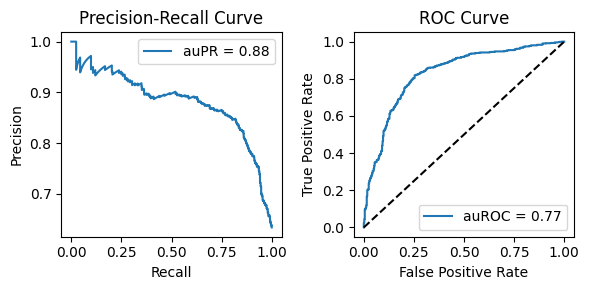

In [5]:
# performance scores based on aim set (ORESAM)
model = joblib.load('models/xgb_opt_trained.joblib')
sel_features = pd.read_csv('data/meta/xgb_selected_features.csv').iloc[:, 0].tolist()

data_aim = pd.read_csv('/mnt/c/Users/ennas/Desktop/ML_genomics/project_1_pcg/ORESAM_features_target.csv')
features_aim = data_aim[sel_features]
target_aim = data_aim['TSE']

plot_ORESAM = plot_evaluation_metrics(model, features_aim, target_aim)
plot_ORESAM.savefig('figures/ORESAM_aimset_performance.svg', bbox_inches='tight')


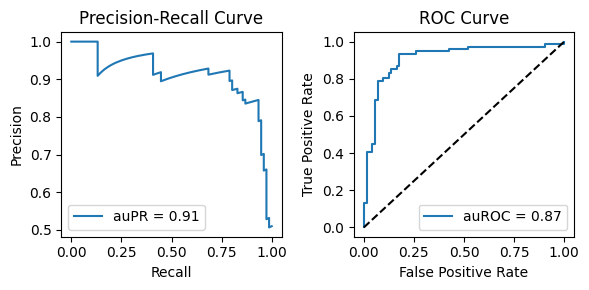

In [6]:
# performance scores based on test set (FRZI)
data = pd.read_csv('data/processed/FRZI_features_target.csv', index_col=0)
features_train, features_test, target_train, target_test = train_test_split(data.drop('TSE', axis=1), data.loc[:, 'TSE'], 
                                                                            test_size=0.1, random_state=42)

plot_FRZI = plot_evaluation_metrics(model, features_test[sel_features], target_test)
plot_FRZI.savefig('figures/FRZI_testset_performance.svg', bbox_inches='tight')


In [30]:
# classification reports
print('aimset (ORESAM):')
print(classification_report(target_aim, model.predict(features_aim[sel_features])))
print()
print('testset (FRZI):')
print(classification_report(target_test, model.predict(features_test[sel_features])))

aimset (ORESAM):
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       406
           1       0.82      0.86      0.84       702

    accuracy                           0.79      1108
   macro avg       0.78      0.77      0.77      1108
weighted avg       0.79      0.79      0.79      1108


testset (FRZI):
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        73
           1       0.84      0.93      0.88        76

    accuracy                           0.87       149
   macro avg       0.88      0.87      0.87       149
weighted avg       0.88      0.87      0.87       149



The model maintains strong performance for positive class predictions across both the aimset and test set, yet it shows a slight decrease in accurately identifying negative cases in the aimset, highlighted by reduced precision and recall for the negative class. This results in a higher number of both false positives and false negatives, particularly the former. The disparity in performance, especially the increased false positive rate on the aimset, is reflected in the differences in auPR and auROC scores, since auROC is sensitive to the false positive rate, which is affected by the number of true negatives. 

From a biological perspective, the observed differences in accurately identifying the negative class could suggest variations in the underlying factors that contribute to non-overexpression at lower temperatures between the FR/ZI and ORE/SAM fly lines. These differences may influence the model's ability to generalize its predictions across different biological contexts.

Overall, the model shows strong performance on both datasets, indicating its effectiveness in handling different biological contexts.


 ---
###### The versions of the software used in this notebook were as follows:

###### joblib: 1.3.2 - matplotlib: 3.8.3 - numpy: 1.26.4 - pandas: 2.2.0 - python: 3.9.16 - scikit-learn: 1.4.1.post1 - xgboost: 2.0.3

###### bcftools: 1.7-2 - bedtools: 2.26.0 - bwa: 0.7.17 - gatk: 4.5.0.0 - mafft: 7.310-1 - pigz: 2.4-1 - samtools: 1.7-1 - sratoolkit: 3.0.10 - STAR: 2.6.1d - subread: 1.6.0 - trim_galore: 0.6.10

###### edgeR: 4.0.14 - optparse: 1.7.3 - PWMEnrich.Dmelanogaster.background_4.36.0 - PWMEnrich_4.38.0 - R: 4.3.2
